# Environment Setup

We start by importing the libraries and modules needed for this analysis.

In [1]:
# For reading, handling data
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from PIL import Image

# For displaying images, plotting metrics, etc.
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

# PyTorch module for loading data
from torch import Generator
from torch.utils.data import DataLoader

# Torchvision modules for computer vison and image handling
import torchvision
from torchvision import datasets, transforms

# For displaying commands in each cell
from IPython.core.interactiveshell import InteractiveShell

# tqdm allows us to display a progress bar for long loops
from tqdm import tqdm 

# Display output of every command in a cell
InteractiveShell.ast_node_interactivity = 'all'

# Progress bar for pandas
tqdm.pandas()

# Set seaborn style and color palette
sns.set_style('darkgrid')
my_palette = ['#D62828','#003049','#F77F00','#FCBF49','#EAE2B7','#6E9075','#EFBDEB','#1B998B','#F0F757','#777DA7']
sns.set_palette(my_palette, n_colors=10)

# Set seed for random sampling of torch loaders
SEED = 42

# Data Exploration

Prior to building the model, we explore the data. The dataset consists of images of different animals stored as JPEGs, with each animal grouped into one subfolder with the animal name (in Italian!). Let's start by studying the class distribution. Rather than read each JPEG, we will just count the number of files in each folder which will speed up the process.

In [2]:
# Root path to all images and
ROOT_PATH = '/kaggle/input/animals10/raw-img/'

# Path for all outputs
OUT_PATH = '/kaggle/working/'

# Folder for figures
FIGURE_PATH = os.path.join(OUT_PATH, 'figures')
if not os.path.exists(FIGURE_PATH):
    os.mkdir(FIGURE_PATH)

# Since animal names are in italian we will have to translate into English
translate = {'cane': 'Dog', 
             'cavallo': 'Horse', 
             'elefante': 'Elephant', 
             'farfalla': 'Butterfly', 
             'gallina': 'Chicken', 
             'gatto': 'Cat', 
             'mucca': 'Cow', 
             'pecora': 'Sheep', 
             'ragno': 'Spider', 
             'scoiattolo': 'Squirrel'
            }

# Walk through the root dir and get the folder and file name for each image
paths, files = zip(*[(path[0], file) for path in os.walk(ROOT_PATH) for file in path[2]])

# Create pandas dataframe to store image path data
df_files = pd.DataFrame({'path': paths, 'file': files})

# Get the English name of the animal for each folder
df_files['label'] = df_files['path'].str.split('/').str[-1].apply(lambda x: translate[x])

# Group by label and sort by the size of the group
df_files = df_files.iloc[df_files.groupby('label').transform('size').argsort(kind='mergesort')].reset_index(drop=True)

# Inspect
df_files.info()
df_files.head()

df_counts = df_files['label'].value_counts()
df_fracs = df_files['label'].value_counts(normalize=True)

df_counts
df_fracs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26179 entries, 0 to 26178
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    26179 non-null  object
 1   file    26179 non-null  object
 2   label   26179 non-null  object
dtypes: object(3)
memory usage: 613.7+ KB


,path,file,label
0,/kaggle/input/animals10/raw-img/elefante,OIP-QeF6RwJQuXjYWQOXa4PLGwHaE6.jpeg,Elephant
1,/kaggle/input/animals10/raw-img/elefante,OIP-GIzroxEWulvjZ6Me9KFSnwHaFj.jpeg,Elephant
2,/kaggle/input/animals10/raw-img/elefante,OIP--UnQR8C6k6T8rQuJOQ87QgHaFj.jpeg,Elephant
3,/kaggle/input/animals10/raw-img/elefante,eb3cb80d2ff2023ed1584d05fb1d4e9fe777ead218ac10...,Elephant
4,/kaggle/input/animals10/raw-img/elefante,OIP-Lbhfmoj1wIbVE55UJcTWhAHaFm.jpeg,Elephant


label
Dog          4863
Spider       4821
Chicken      3098
Horse        2623
Butterfly    2112
Cow          1866
Squirrel     1862
Sheep        1820
Cat          1668
Elephant     1446
Name: count, dtype: int64

label
Dog          0.185760
Spider       0.184155
Chicken      0.118339
Horse        0.100195
Butterfly    0.080675
Cow          0.071279
Squirrel     0.071126
Sheep        0.069521
Cat          0.063715
Elephant     0.055235
Name: proportion, dtype: float64

We know the dataset contains 26179 images. Let's get a visualization of the class distribution in the dataset.

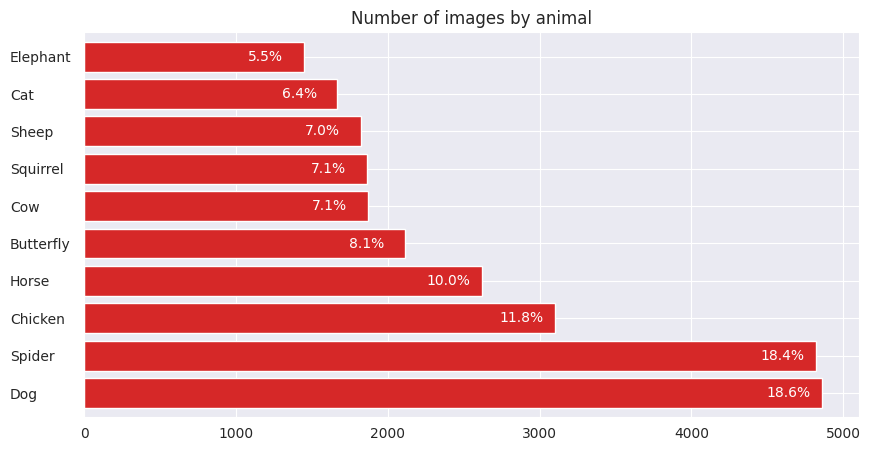

In [3]:
# Plot the file counts
ax = df_counts.plot(figsize=(10,5), kind='barh', width=.8, title='Number of images by animal')

# Annotate bars with the percentage
percent_labels = [f'{100*p:.1f}%' for p in df_fracs]
ax.bar_label(ax.containers[0], labels=percent_labels, label_type='edge', fontsize=10, color='white', padding=-40)

# Clean up y-axis labels
ax.set(ylabel=None)
ax.tick_params(axis='y', pad=50)  
ax.set_yticklabels(ax.get_yticklabels(), ha='left')

# Save figure
plt.savefig(os.path.join(FIGURE_PATH,'file-counts.pdf'), bbox_inches='tight');

The classes are not balanced. Images of dogs and spiders make up 37% of the dataset in almost equal portions, while the rest of the animals each constitute between 5-10% of the dataset. To reduce training bias toward dogs and spiders, we will oversample the minority classes while applying image augmentation, so that the class distribution is approximately balanced. This will be performed in the model training notebook (2).

Now let's inspect the contents of the individual files, i.e., let's study the images' spatial dimensions and display a few images to confirm the class labels are consistent.

In [4]:
# Open up each image as a PIL and get the size, returning the height and width as two new columns in the df
df_files[['image_height','image_width']] = df_files.progress_apply(lambda x: Image.open(os.path.join(x.path, x.file)).size, axis=1, result_type='expand')

100%|██████████| 26179/26179 [02:22<00:00, 183.75it/s]


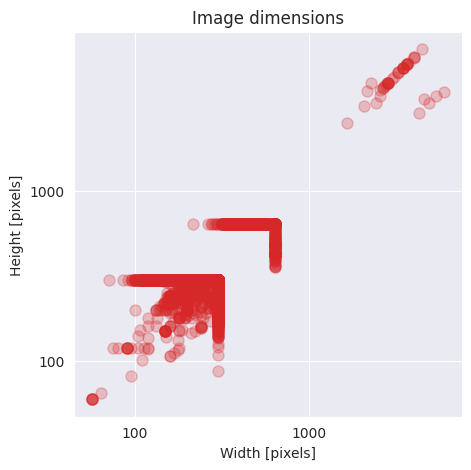

In [5]:
# Plot data as scatter plot with translucent markers
ax = df_files.plot(kind='scatter', x='image_width', y='image_height', figsize=(5, 5), title='Image dimensions', logx=True, logy=True, s=64, alpha=0.25)

# Clean up x- and y-axes
ax.set_ylabel('Height [pixels]')
ax.set_xlabel('Width [pixels]')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())

# Save the figure
plt.savefig(os.path.join(FIGURE_PATH,'image-dims.pdf'), bbox_inches='tight');

The image dimensions widely vary but are clustered into three groups: widths/heights between 50 and 300 pixels, which is where most of the data appear; widths/heights between 600 and 700 pixels; and a small collection of outliers with very large resolution over 1000 x 1000 pixels. We will use this figure to guide how we crop the images, since every tensor representing an image must be uniform in size among the input data when training and evaluating the model. Let's take a closer look at the distribution without the outliers.

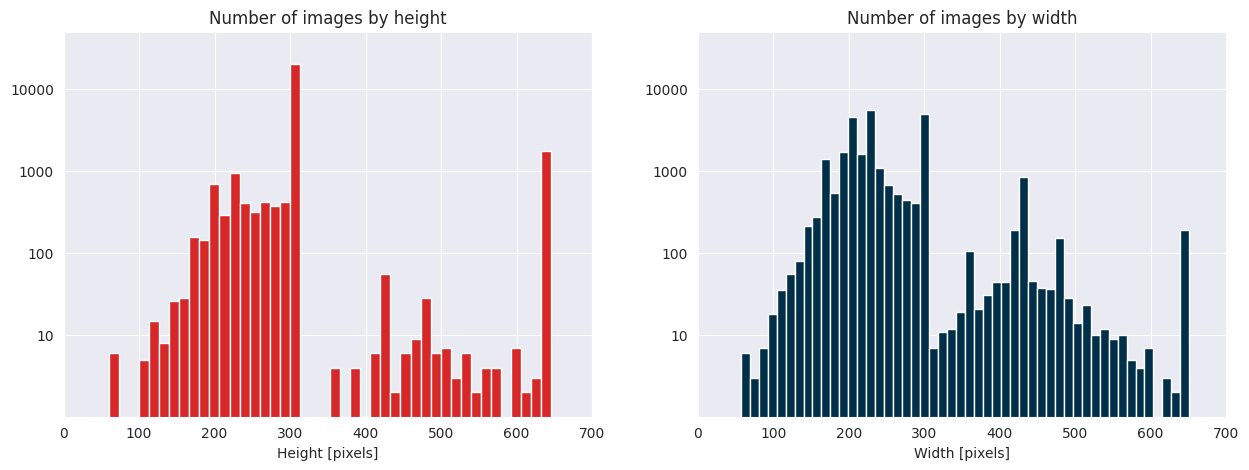

In [6]:
# Create fig and subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# Plot the different image dimensions and their frequencies
df_files['image_height'].plot(kind='hist', bins=500, logy=True, title='Number of images by height', color=my_palette[0], alpha=1, ax=ax[0]) 
df_files['image_width'].plot(kind='hist', bins=500, logy=True, title='Number of images by width', color=my_palette[1], alpha=1, ax=ax[1]) 

# Truncate hist to remove outliers
ax[0].set_xlim([0, 700])
ax[1].set_xlim([0, 700])

# Match y-axes between subplots
ax[0].set_ylim([1.01, 50000])
ax[1].set_ylim([1.01, 50000])

# Clean up x- and y-axes
ax[0].set_ylabel(None)
ax[1].set_ylabel(None)
ax[0].set_xlabel('Height [pixels]')
ax[1].set_xlabel('Width [pixels]')
ax[0].yaxis.set_major_formatter(ScalarFormatter())
ax[1].yaxis.set_major_formatter(ScalarFormatter())

# Save the figure
plt.savefig(os.path.join(FIGURE_PATH,'image-dims_hist.pdf'), bbox_inches='tight');

I think it is clear from these histograms that fixing images to 300 x 300 pixels will require the fewest transformations. To ensure every image is 300 x 300 pixels, we apply two transformations:
1. Pad each side of every image with a zero-valued/black 300-pixel-wide border
2. Center-crop each padded image to a 300 x 300 pixel grid

These transformations will minimize the amount of padding for the smaller images and minimize loss of information when cropping the larger images. 

Now we'll plot a few transformed images loaded as tensors with torchvision. This is a sanity check to see that the image data are appropriate, the transforms are applied, and the class labels are correct.

In [7]:
IMAGE_SIZE = 300

# Define the transforms to perform on each image
my_transforms = transforms.Compose([transforms.ToTensor(),
                                    transforms.Pad(IMAGE_SIZE),
                                    transforms.CenterCrop(IMAGE_SIZE)
                                   ])

# The ImageFolder class does not read any images into memory
# It will only read and load images when we access an element
dataset = datasets.ImageFolder(ROOT_PATH, transform=my_transforms)

# Confirm size of dataset
len(dataset)

# Get mapping from class index to English label for plot lables
dataset.class_to_idx
idx_to_label = {idx: translate[class_ita] for class_ita, idx in dataset.class_to_idx.items()}

# Inspect one image and get the shape
image, class_idx = dataset[0]
image.shape

26179

{'cane': 0,
 'cavallo': 1,
 'elefante': 2,
 'farfalla': 3,
 'gallina': 4,
 'gatto': 5,
 'mucca': 6,
 'pecora': 7,
 'ragno': 8,
 'scoiattolo': 9}

torch.Size([3, 300, 300])

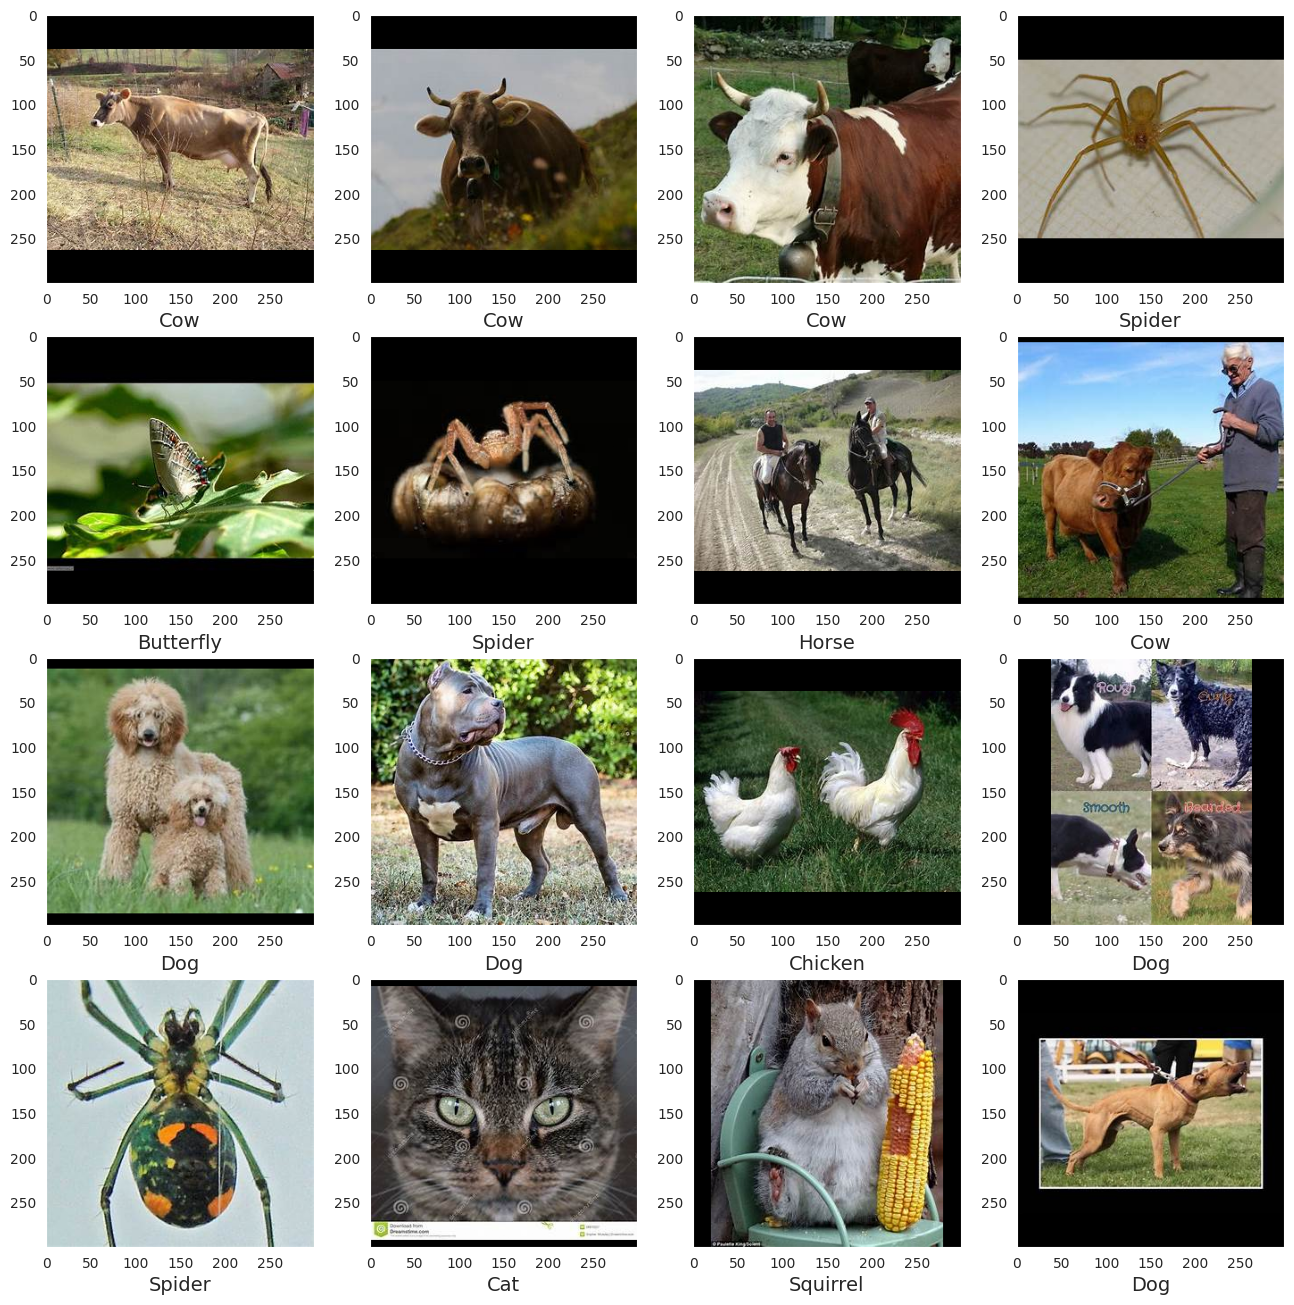

In [8]:
# Create dataloader to randomly sample images
loader = DataLoader(dataset, shuffle=True, generator=Generator('cpu').manual_seed(SEED))

# Create figure with 4 x 4 subplots
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16,16))

# Plot first 16 in random sample
for row in range(4):
    for col in range(4):
        
        # Grab the image tensor and label (class index)
        features, labels = next(iter(loader))
        
        # Tensors are of dimension (channel, width, height) but to plot we want (width, height, channel), so permute the dimensions
        ax[row, col].imshow(features[0].permute(1, 2, 0))
        
        # Clean up images
        ax[row, col].grid(False)
        ax[row, col].set_xlabel(idx_to_label[labels[0].item()], size=14)
        
# Save the figure
plt.savefig(os.path.join(FIGURE_PATH,'labeled-image-sample.pdf'), bbox_inches='tight');

By inspection, we can confirm the labels appropriately match the animal depicted in the corresponding image. We also see that the images are properly sized to 300 x 300 pixels, with smaller images are padded and larger images cropped.